In [1]:
# default_exp batteries

# Batteries

A collection of utility functions for converting Kate's Excel Sheet into a set of reproducible batteries that can be easily combined into domains. These contain a set of calculators that convert the data and define raw, calculated, and normalized fields.

In [2]:
# hide
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [37]:
# export



import os
import yaml

import pandas as pd
import numpy as np

from autoneuro.calculators import *
from autoneuro.operators import *
from autoneuro.field_mapping import *

We'll need some data to properly test all of these.

In [38]:
SHOW_DATA = 'new' # new or old

if SHOW_DATA == 'new':
    paths = [('redcap_id', 'data/ducomout/ClinicalAndTranslati_DATA_2021-04-24_1737.csv'),
             ('cnns_id', 'data/cnns/EXPORT_DD.csv')]
    req_fields = ['bvmt_trial1', 'cnns_bvmt_t']
else:
    paths = [('oldneuro_id', 'data/neuro_data.xlsx')]
    req_fields = ['bvmt_trial1']


mapper = FieldMapper.from_file('data/field_mappings_merged.xlsx', post_convert=[fix_study_ids, fix_dates])
map_neuro = mapper.multi_merge('internal_field', paths, index_keys = ['study_id', 'date_of_visit']).dropna(subset = req_fields)
map_neuro.head()

/home/will/anaconda3/envs/autoneuro/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (2,17,18,97,106,109,112,139,140,141,247,254,268,275,279,281,357,358,363,410,411,477,494,505,535,536,541,707,709,711,853,870,884,928,929,930,944,949,959,966,977,987,988,989,995,1004,1005,1006,1012,1019,1021,1022,1023,1029) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,,abdominal_girth,age,age_first_drivers_license,age_first_used_drug,agenp,aids_defining_indicat2_2dd,aids_defining_indicators,also_driving_assessment,amitriptyline_end_date,amitriptyline_start_date,...,year_diagnosed_tuberculosi,year_diagnosed_uterine_can,year_diagnosed_with_asthma,year_diagnosed_with_copd,year_diagnosed_with_diabet,year_diagnosed_with_elevat,year_diagnosed_with_hypert,years_seropositive,you_get_angry_at_the_behav,you_intend_to_drive_to_des
study_id,date_of_visit,,,,,,,,,,,,,,,,,,,,,
2,2021-03-11,37.5,70.0,30,22yo,70.0,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,0.0,0.0
5,2020-11-19,51.5,61.0,None,None,61.0,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,1964.0,2008.0,2010.0,2014.0,NaN,36 years,NaN,NaN
13,2021-02-25,37.0,75.0,18yo,None,75.0,NaN,NaN,1.0,NaN,NaN,...,1996.0,NaN,NaN,2003.0,2019.0,2007.0,2009.0,23 years,0.0,0.0
25,2021-03-16,47.5,63.0,62yo,16yo,63.0,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,2020.0,2019.0,2009.0,2000.0,21 Years,2.0,1.0
38,2021-01-13,50.0,51.0,30yo,13yo,51.0,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,1973.0,NaN,NaN,2007.0,2012.0,25 years,0.0,0.0


Then we'll need to normalize the field names.

In [6]:
# export
# hide

def create_scaling(scaling_df, raw_field, scaled_field):
    """Returns a dict that can be used to create a BinedscalingOp"""
    edges = scaling_df.groupby(scaled_field)[raw_field].min()
    
    data = {'type': 'binned_scaling',
            'measure_col': raw_field,
            'bins': []}
    data['bins'] = [{'scaled': s, 'min': m} for s, m in edges.to_dict().items()]
    
    return data


def check_battery(battery_cls, neuro_data, check_mean = False):
    
    battery = battery_cls.from_defaults()
    
    clean_data = neuro_data[battery.required_fields].dropna(how = 'all')
    assert len(clean_data.index) > 0, 'No data matching these fields was found.'
    
    results = battery.scaled_data(clean_data)
    
    missing_frac = results.isnull().mean()
    missing_too_much = missing_frac > 0.3
    if missing_too_much.any():
        items = missing_frac[missing_too_much].to_dict().items()
        msg = [f'{field}: {val}' for field, val in items]
        print('Possible exessive Nans: ' + ', '.join(msg))
    
    if battery.z_scaled & check_mean:
        means = results.mean()
        for field, mean in means.to_dict().items():
            assert (mean < 1.6) & (mean > -1.6), f'{field} fell outside expected range: {mean}'
            
    print(battery.explain(clean_data.iloc[0]))
    
    try:
        results.plot(kind = 'hist')    
    except:
        pass
    

# Battery

In the abstract, a battery is a collection of `TestCalculator` objects and definitions about which fields are measurements, infered, and normalized.

In [7]:
# export

class AbstractBattery(object):
    
    section = None
    
    def __init__(self, calculator, scaled_fields, z_scaled = True):
        
        self.calculator = calculator
        self.scaled_fields = scaled_fields
        self.z_scaled = z_scaled
        self.add_operation_field_info()
        
    def add_operation_field_info(self, section = None, origin = None):
        
        if section is None:
            section = self.section
        
        self.calculator.add_operation_field_info(section = section, 
                                                 origin = origin)
        
    @property
    def required_fields(self):
        return self.calculator.fields
        
    def explain(self, data):
        return self.calculator.explain(data)
    
    def __call__(self, df):
        return self.calculator.process_dataframe(df)
    
    def scaled_data(self, df):
        
        data = self.calculator.process_dataframe(df)
        return data[self.scaled_fields]
        
    @classmethod
    def check_battery(battery_cls, data):
        check_battery(battery_cls, data, check_mean = False)
        

## Brief Visiospatial Memory Test

In [8]:
# export 
# hide

class BVMTBattery(AbstractBattery):
    
    section = 'BVMT-R'
    
    @staticmethod
    def from_defaults(root_data = 'data/'):
        
        bvmt_test_definition = os.path.join(root_data, 'test_calculators/BVMT.yaml')
        bvmt_calc = TestCalculator.from_config(yaml.full_load(open(bvmt_test_definition)))
        
        heaton_norm_definition = os.path.join(root_data, 'norms/from_kate/heaton_bvmt.yaml')
        heaton_bvmt_calc = TestCalculator.from_config(yaml.full_load(open(heaton_norm_definition)))
        
        return BVMTBattery(bvmt_calc + heaton_bvmt_calc, 
                           ['bvmt_immediate_heaton_z','bvmt_retention_heaton_z'])
        


Input: 
 age:59.0
 bvmt_delay:0.0
 bvmt_false_pos:3.0
 bvmt_hits:6.0
 bvmt_trial1:2.0
 bvmt_trial2:5.0
 bvmt_trial3:5.0
Calculating: ['bvmt_immediate']
Used Equation: bvmt_trial1+bvmt_trial2+bvmt_trial3 = 12.0 = bvmt_immediate 

Calculating: ['bvmt_retention_denom']
Aggregation: max [bvmt_trial2, bvmt_trial3]  = 5.0 

Calculating: ['bvmt_learning']
Used Equation: bvmt_retention_denom - bvmt_trial1 = 3.0 = bvmt_learning 

Calculating: ['bvmt_retention']
Used Equation: 100*(bvmt_delay/bvmt_retention_denom) = 0.0 = bvmt_retention 

Calculating: ['bvmt_retention']
Clipped bvmt_retention to [0, 100] 

Calculating: ['bvmt_recognition']
Used Equation: bvmt_hits-bvmt_false_pos = 3.0 = bvmt_recognition 

Calculating: ['bvmt_immediate_heaton_z']
Matched: (59 <= age) & (age <= 62)
Expected 22.66+/-5.39 but observed 12.0
Scaled to: z=-1.9777365491651206 

Calculating: ['bvmt_retention_heaton_z']
Matched: (59 <= age) & (age <= 62)
Expected 93.7+/-8.7 but observed 0.0
Scaled to: z=-10.77011494252873

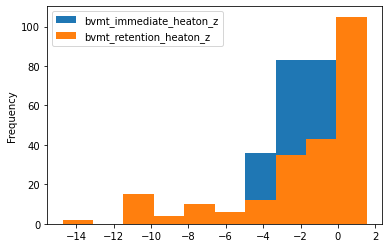

In [9]:
BVMTBattery.check_battery(map_neuro)

In [10]:
bvmt = BVMTBattery.from_defaults()

odf = bvmt.calculator.process_dataframe(map_neuro)
odf.head()

age  bvmt_delay  bvmt_false_pos  bvmt_hits  bvmt_trial1  \
PatientID Visit                                                             
1         1      59.0         0.0             3.0        6.0          2.0   
          2      62.0        28.0            10.0        9.0          NaN   
2         1      62.0         0.0             3.0        5.0          0.0   
          2      67.0         9.5            10.0        9.0          NaN   
4         1      65.0         4.0             0.0        4.0          3.0   

                 bvmt_trial2  bvmt_trial3  bvmt_immediate  \
PatientID Visit                                             
1         1              5.0          5.0            12.0   
          2              NaN          NaN             NaN   
2         1              0.0          1.0             1.0   
          2              NaN          NaN             NaN   
4         1              4.0          3.0            10.0   

                 bvmt_retention_denom  bvmt_learning  bvmt_retention  \
PatientID Visit                                                        
1         1                       5.0            3.0             0.0   
          2                       NaN            NaN             NaN   
2         1                       1.0            1.0             0.0   
          2                       NaN            NaN             NaN   
4         1                       4.0            1.0           100.0   

                 bvmt_recognition  bvmt_immediate_heaton_z  \
PatientID Visit                                              
1         1                   3.0                -1.977737   
          2                  -1.0                      NaN   
2         1                   2.0                -4.018553   
          2                  -1.0                      NaN   
4         1                   4.0                -2.190909   

                 bvmt_retention_heaton_z  bvmt_delay_heaton_z  \
PatientID Visit                                                 
1         1                   -10.770115            -4.032864   
          2                          NaN             9.112676   
2         1                   -10.770115            -4.032864   
          2                          NaN             0.592105   
4         1                     0.905172            -1.986364   

                 bvmt_recognition_heaton_z  
PatientID Visit                             
1         1                      -6.500000  
          2                     -15.590909  
2         1                      -8.772727  
          2                      -6.968085  
4         1                      -4.000000

In [11]:
bvmt.explain(map_neuro.iloc[5])

Input: 
 age:54
 bvmt_delay:7.0
 bvmt_false_pos:0.0
 bvmt_hits:3.0
 bvmt_trial1:3.0
 bvmt_trial2:5.0
 bvmt_trial3:5.0
Calculating: ['bvmt_immediate']
Used Equation: bvmt_trial1+bvmt_trial2+bvmt_trial3 = 13.0 = bvmt_immediate 

Calculating: ['bvmt_retention_denom']
Aggregation: max [bvmt_trial2, bvmt_trial3]  = 5.0 

Calculating: ['bvmt_learning']
Used Equation: bvmt_retention_denom - bvmt_trial1 = 2.0 = bvmt_learning 

Calculating: ['bvmt_retention']
Used Equation: 100*(bvmt_delay/bvmt_retention_denom) = 140.0 = bvmt_retention 

Calculating: ['bvmt_retention']
Clipped bvmt_retention to [0, 100] 

Calculating: ['bvmt_recognition']
Used Equation: bvmt_hits-bvmt_false_pos = 3.0 = bvmt_recognition 

Calculating: ['bvmt_immediate_heaton_z']
Matched: (54 <= age) & (age <= 58)
Expected 23.27+/-5.28 but observed 13.0
Scaled to: z=-1.9450757575757573 

Calculating: ['bvmt_retention_heaton_z']
Matched: (54 <= age) & (age <= 58)
Expected 94.0+/-8.43 but observed 100.0
Scaled to: z=0.7117437722419

## HVLT

In [12]:
# export 
# hide

class HVLTBattery(AbstractBattery):
    
    section = 'HVLT-R'
    
    @staticmethod
    def from_defaults(root_data = 'data/'):
        
        hvlt_test_definition = os.path.join(root_data, 'test_calculators/HVLT.yaml')
        hvlt_calc = TestCalculator.from_config(yaml.full_load(open(hvlt_test_definition)))
        
        heaton_hvlt_norm_definition = os.path.join(root_data, 'norms/from_kate/heaton_hvlt.yaml')
        heaton_hvlt_calc = TestCalculator.from_config(yaml.full_load(open(heaton_hvlt_norm_definition)))
        
        return HVLTBattery(heaton_hvlt_calc+hvlt_calc, 
                           ['hvlt_recognition_heaton_z', 'hvlt_delay_heaton_z', 'hvlt_total_heaton_z'])

Possible exessive Nans: hvlt_recognition_heaton_z: 0.8913738019169329, hvlt_delay_heaton_z: 0.6166134185303515, hvlt_total_heaton_z: 0.6166134185303515
Input: 
 age:59.0
 hvlt1intr:nan
 hvlt1pers:nan
 hvlt2pers:nan
 hvlt_delay:nan
 hvlt_false_pos:nan
 hvlt_hits:nan
 hvlt_trial1:nan
 hvlt_trial2:nan
 hvlt_trial3:nan
Calculating: ['hvlt_total']
Used Equation: hvlt_trial1+hvlt_trial2+hvlt_trial3 = nan = hvlt_total 

Calculating: ['hvlt_recognition']
Used Equation: hvlt_hits+hvlt_false_pos = nan = hvlt_recognition 

Calculating: ['hvlt_total_heaton_z']
Matched: age >= 54
Expected 27.86+/-3.95 but observed nan
Scaled to: z=nan 

Calculating: ['hvlt_delay_heaton_z']
Matched: age >= 54
Expected 10.06+/-1.73 but observed nan
Scaled to: z=nan 

Calculating: ['hvlt_recognition_heaton_z']
Matched: age >= 54
Expected 10.79+/-1.61 but observed nan
Scaled to: z=nan 

Calculating: ['hvlt_immediate']
Used Equation: hvlt_trial1+hvlt_trial2+hvlt_trial3 = nan = hvlt_immediate 

Calculating: ['hvlt_retent

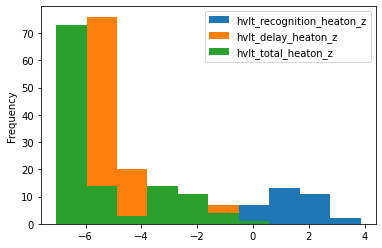

In [13]:
HVLTBattery.check_battery(map_neuro)

## SENAS Wordlist

In [14]:
# export 
# hide

class SENASWordlistBattery(AbstractBattery):
    
    source = 'SENAS Word List Learning'
    
    @staticmethod
    def from_defaults(root_data = 'data/'):
        
        senas_wordlist_definition = os.path.join(root_data, 'norms/senas/worldlist_learning.yaml')
        senas_wordlist_calc = TestCalculator.from_config(yaml.full_load(open(senas_wordlist_definition)))
        
        return SENASWordlistBattery(senas_wordlist_calc, 
                                    ['senas_wordlist_total'],
                                    z_scaled=False)

Possible exessive Nans: senas_wordlist_total: 0.3079710144927536
Input: 
 senas_wordlist_t1:4.0
 senas_wordlist_t2:10.0
 senas_wordlist_t3:10.0
 senas_wordlist_t4:12.0
 senas_wordlist_t5:11.0
Calculating: ['senas_wordlist_total']
Used Equation: senas_wordlist_t1 + senas_wordlist_t2 + senas_wordlist_t3 + senas_wordlist_t4 + senas_wordlist_t5 = 47.0 = senas_wordlist_total 

Calculating: ['senas_wordlist_total_plc']
Used Equation: senas_wordlist_total = 47.0 = senas_wordlist_total_plc 

Resulting in: 
 senas_wordlist_total:47.0
 senas_wordlist_total_plc:47.0
None


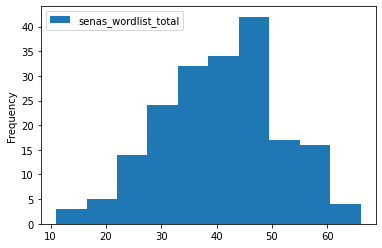

In [15]:
SENASWordlistBattery.check_battery(map_neuro)

## Letter Fluency

In [16]:
# export
# hide

class LetterFluencyBattery(AbstractBattery):
    
    section = 'Letter Fluency'
    
    @staticmethod
    def from_defaults(root_data = 'data/'):
        
        phenomic_placeholder = os.path.join(root_data, 'norms/placeholders/letter_fluency.yaml')
        phenomic_calc = TestCalculator.from_config(yaml.full_load(open(phenomic_placeholder)))

        return LetterFluencyBattery(phenomic_calc, 
                                    ['letterfluencyfas_total_heaton_z'],
                                    z_scaled=True)

Input: 
 age:59.0
 education:10.0
 letterfluencya_intr:0.0
 letterfluencya_pers:0.0
 letterfluencya_q1:0.0
 letterfluencya_q2:2.0
 letterfluencya_q3:2.0
 letterfluencya_q4:1.0
 letterfluencyf_intr:0.0
 letterfluencyf_pers:0.0
 letterfluencyf_q1:4.0
 letterfluencyf_q2:1.0
 letterfluencyf_q3:0.0
 letterfluencyf_q4:0.0
 letterfluencys_intr:0.0
 letterfluencys_pers:0.0
 letterfluencys_q1:1.0
 letterfluencys_q2:1.0
 letterfluencys_q3:3.0
 letterfluencys_q4:1.0
Calculating: ['letterfluencyf_total']
Used Equation: letterfluencyf_q1+letterfluencyf_q2+letterfluencyf_q3+letterfluencyf_q4 = 5.0 = letterfluencyf_total 

Calculating: ['letterfluencya_total']
Used Equation: letterfluencya_q1+letterfluencya_q2+letterfluencya_q3+letterfluencya_q4 = 5.0 = letterfluencya_total 

Calculating: ['letterfluencys_total']
Used Equation: letterfluencys_q1+letterfluencys_q2+letterfluencys_q3+letterfluencys_q4 = 6.0 = letterfluencys_total 

Calculating: ['letterfluencyfas_pers']
Used Equation: letterfluencyf_per

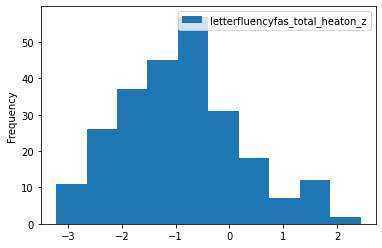

In [17]:
LetterFluencyBattery.check_battery(map_neuro)

## Category Fluency - Animals

In [18]:
# export 
# hide

class CategoryFluencyAnimalsBattery(AbstractBattery):
    
    section = 'Category Fluency: Animals'
    
    @staticmethod
    def from_defaults(root_data = 'data/'):
        
        heaton_gender = CategoricalOp('sex', {'male': 1, 'female': 2, 1: 1, 2: 2}, 'heaton_gender')
        heaton_race = CategoricalOp('race', {'AA': 1, 'white': 2, 'asian': 2, 2: 1, 1: 2}, 'heaton_race')        
        
        total_op = EquationOp("categoryfluency_total",
                              "categoryfluency_q1+categoryfluency_q2+categoryfluency_q3+categoryfluency_q4",
                              ['categoryfluency_q1', 'categoryfluency_q2', 'categoryfluency_q3', 'categoryfluency_q4'])
        
        heaton_scaling = pd.read_csv('data/norms/from_kate/sheets/Heaton.csv')
        cat_scaling = create_scaling(heaton_scaling, 'categoryfluency_total', 'categoryfluency_total_scaled')
        
        cat_heaton_2 = MultiLookupOp.from_sheet_format('data/norms/from_kate/sheets/Animals.csv',
                                                          HEATON_MAPPINGS,
                                                          ['age', 'heaton_gender','heaton_race',  'education'],
                                                          'categoryfluency_total_scaled',
                                                          'categoryfluency_total_heaton_z',
                                                          extra_filter = 'heaton_race == 2')
        


        cat_heaton_1 = MultiLookupOp.from_sheet_format('data/norms/from_kate/sheets/Animals_AA.csv',
                                                          HEATON_MAPPINGS,
                                                          ['age', 'heaton_gender','heaton_race',  'education'],
                                                          'categoryfluency_total_scaled',
                                                          'categoryfluency_total_heaton_z',
                                                          extra_filter = 'heaton_race == 1')
        
        
        cat_heaton_1.incoperate(cat_heaton_2)
    
        
        scaler = TestCalculator('Animals_scaling',
                               [heaton_gender, heaton_race,
                                total_op,
                                AbstractOperation.from_config(cat_scaling),
                                cat_heaton_1
                               ])
        
        return CategoryFluencyAnimalsBattery(scaler, 
                                      ['categoryfluency_total_heaton_z'])

Input: 
 age:59
 categoryfluency_q1:5.0
 categoryfluency_q2:5.0
 categoryfluency_q3:4.0
 categoryfluency_q4:0.0
 education:10
 race:AA
 sex:male
Calculating: ['heaton_gender']
sex:male -> heaton_gender:1 

Calculating: ['heaton_race']
race:AA -> heaton_race:1 

Calculating: ['categoryfluency_total']
Used Equation: categoryfluency_q1+categoryfluency_q2+categoryfluency_q3+categoryfluency_q4 = 14.0 = categoryfluency_total 

Calculating: ['categoryfluency_total_scaled']
categoryfluency_total matched 14.0, scaled to 7.0 

Calculating: ['categoryfluency_total_heaton_z']
Matched: (heaton_race == 1) & ((age >= 50) & ((9 < education) & (education <= 12)) & (heaton_gender == 1))
Mapped to: 34
Scaled to: z=-1.6 

Resulting in: 
 categoryfluency_total:14.0
 categoryfluency_total_heaton_z:-1.6
 categoryfluency_total_scaled:7.0
 heaton_gender:1
 heaton_race:1
None


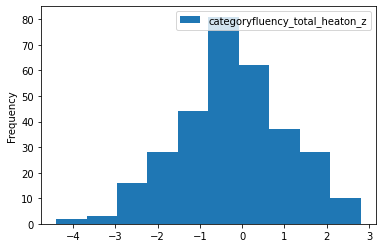

In [19]:
CategoryFluencyAnimalsBattery.check_battery(map_neuro)

## BNT-30

In [20]:
# export 
# hide

class BNT30Battery(AbstractBattery):
    
    section = 'Boston Naming Test-30 (BNT-30)'
    
    @staticmethod
    def from_defaults(root_data = 'data/', final_cols = None):
        
        total_op = EquationOp("bnt30_plc",
                              "bnt30",
                              ['bnt30'])

        
        calc = TestCalculator('bnt30_placeholder',
                              [total_op])
        
        return BNT30Battery(calc, 
                            ['bnt30_plc'],
                            z_scaled=False)

In [21]:
#BNT30Battery.check_battery(map_neuro)

## Clock Drawing

Completely placeholder

In [22]:
# export 
# hide

class ClockDrawingBattery(AbstractBattery):
    
    section = 'Visuoconstruction'
    
    @staticmethod
    def from_defaults(root_data = 'data/', final_cols = None):
        
        sum_op = EquationOp("clocksum",
                            "clockcommand2+clockcopy2",
                            ['clockcommand2', 'clockcopy2'])

        plc_op = EquationOp("clocksum_plc",
                            "clocksum",
                            ['clocksum'])
        
        calc = TestCalculator('clockdrawing',
                              [sum_op, plc_op])
        
        return ClockDrawingBattery(calc, 
                                   ['clocksum_plc'],
                                   z_scaled=False)

In [23]:
#ClockDrawingBattery.check_battery(map_neuro)

## ROCF

Completely placeholder

In [24]:
# export 
# hide

class ROCFBattery(AbstractBattery):
    section = 'Visuoconstruction'
    
    @staticmethod
    def from_defaults(root_data = 'data/', final_cols = None):
        
        total_op = EquationOp("rocf_plc",
                              "rocf",
                              ['rocf', 'rocftime'])

        
        calc = TestCalculator('rocf_placeholder',
                              [total_op])
        
        return ROCFBattery(calc, 
                           ['rocf_plc'],
                           z_scaled=False)

Input: 
 rocf:29.0
 rocftime:417.0
Calculating: ['rocf_plc']
Used Equation: rocf = 29.0 = rocf_plc 

Resulting in: 
 rocf_plc:29.0
None


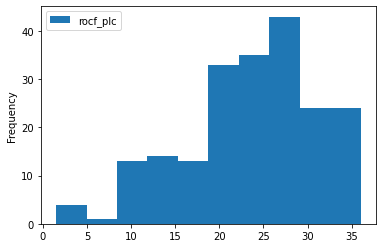

In [25]:
ROCFBattery.check_battery(map_neuro)

## Grooved Peg Board

In [26]:
# export 
# hide

class GroovedPegBoardBattery(AbstractBattery):
    
    section = 'Grooved Pegboard'
    
    @staticmethod
    def from_defaults(root_data = 'data/'):
        
        heaton_gender = CategoricalOp('sex', {'male': 1, 'female': 2,
                                              1: 1, 2: 2}, 'heaton_gender')
        heaton_race = CategoricalOp('race', {'AA': 1, 'white': 2, 'asian': 2, 4: 2,
                                             1: 2, 2: 1}, 'heaton_race')
        
        heaton_scaling = pd.read_csv('data/norms/from_kate/sheets/Heaton.csv')
        gpd = create_scaling(heaton_scaling, 'groovedpegdom', 'groovedpegdom_scaled')
        gpn = create_scaling(heaton_scaling, 'groovedpegnondom', 'groovedpegnondom_scaled')
        
        grooved_peg_dom_2 = MultiLookupOp.from_sheet_format('data/norms/from_kate/sheets/GPD.csv',
                                                          HEATON_MAPPINGS,
                                                          ['age', 'heaton_gender','heaton_race',  'education'],
                                                          'groovedpegdom_scaled',
                                                          'groovedpegdom_heaton_z',
                                                          extra_filter = 'heaton_race == 2')
        
        grooved_peg_ndom_2 = MultiLookupOp.from_sheet_format('data/norms/from_kate/sheets/GPN.csv',
                                                          HEATON_MAPPINGS,
                                                          ['age', 'heaton_gender', 'heaton_race', 'education'],
                                                          'groovedpegnondom_scaled',
                                                          'groovedpegnondom_heaton_z',
                                                          extra_filter = 'heaton_race == 2')

        grooved_peg_dom_1 = MultiLookupOp.from_sheet_format('data/norms/from_kate/sheets/GPD_AA.csv',
                                                          HEATON_MAPPINGS,
                                                          ['age', 'heaton_gender','heaton_race',  'education'],
                                                          'groovedpegdom_scaled',
                                                          'groovedpegdom_heaton_z',
                                                          extra_filter = 'heaton_race == 1')
        
        grooved_peg_ndom_1 = MultiLookupOp.from_sheet_format('data/norms/from_kate/sheets/GPN_AA.csv',
                                                          HEATON_MAPPINGS,
                                                          ['age', 'heaton_gender', 'heaton_race', 'education'],
                                                          'groovedpegnondom_scaled',
                                                          'groovedpegnondom_heaton_z',
                                                          extra_filter = 'heaton_race == 1')
        
        grooved_peg_dom_1.incoperate(grooved_peg_dom_2)
        grooved_peg_ndom_1.incoperate(grooved_peg_ndom_2)

        mean_op = EquationOp('groovedpegboth',
                              '(groovedpegdom+groovedpegnondom)/2',
                              ['groovedpegdom', 'groovedpegnondom'])
    
        
        
        scaler = TestCalculator('grooved_pegboard_scaling',
                               [heaton_gender, heaton_race, mean_op,
                                AbstractOperation.from_config(gpd),
                                AbstractOperation.from_config(gpn),
                                grooved_peg_dom_1, grooved_peg_ndom_1,
                               ])
        
        return GroovedPegBoardBattery(scaler, 
                           ['groovedpegdom_heaton_z', 'groovedpegnondom_heaton_z'])

Input: 
 age:59
 education:10
 groovedpegdom:98.0
 groovedpegnondom:140.0
 race:AA
 sex:male
Calculating: ['heaton_gender']
sex:male -> heaton_gender:1 

Calculating: ['heaton_race']
race:AA -> heaton_race:1 

Calculating: ['groovedpegboth']
Used Equation: (groovedpegdom+groovedpegnondom)/2 = 119.0 = groovedpegboth 

Calculating: ['groovedpegdom_scaled']
groovedpegdom matched 89.0, scaled to 5.0 

Calculating: ['groovedpegnondom_scaled']
groovedpegnondom matched 131.0, scaled to 3.0 

Calculating: ['groovedpegdom_heaton_z']
Matched: (heaton_race == 1) & ((age >= 50) & ((9 < education) & (education <= 12)) & (heaton_gender == 1))
Mapped to: 34
Scaled to: z=-1.6 

Calculating: ['groovedpegnondom_heaton_z']
Matched: (heaton_race == 1) & ((age >= 50) & ((9 < education) & (education <= 12)) & (heaton_gender == 1))
Mapped to: 25
Scaled to: z=-2.5 

Resulting in: 
 groovedpegboth:119.0
 groovedpegdom_heaton_z:-1.6
 groovedpegdom_scaled:5.0
 groovedpegnondom_heaton_z:-2.5
 groovedpegnondom_sca

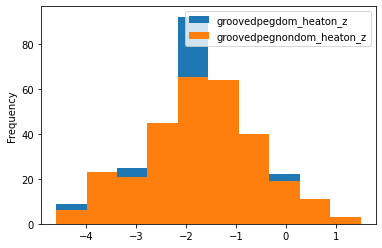

In [27]:
GroovedPegBoardBattery.check_battery(map_neuro)

## Trail A

In [28]:
# export
# hide

class TrailABattery(AbstractBattery):
    
    section = 'Trail Making Test'
    
    @staticmethod
    def from_defaults(root_data = 'data/'):
        
        heaton_gender = CategoricalOp('sex', {'male': 1, 'female': 2, 1: 1, 2: 2}, 'heaton_gender')
        heaton_race = CategoricalOp('race', {'AA': 1, 'white': 2, 'asian': 2, 2: 1, 1: 2}, 'heaton_race')
        
        heaton_scaling = pd.read_csv('data/norms/from_kate/sheets/Heaton.csv')
        traila_scaling = create_scaling(heaton_scaling, 'traila', 'traila_scaled')
        
        traila_heaton_2 = MultiLookupOp.from_sheet_format('data/norms/from_kate/sheets/TrailsA.csv',
                                                          HEATON_MAPPINGS,
                                                          ['age', 'heaton_gender','heaton_race',  'education'],
                                                          'traila_scaled',
                                                          'traila_heaton_z',
                                                          extra_filter = 'heaton_race == 2')
        


        traila_heaton_1 = MultiLookupOp.from_sheet_format('data/norms/from_kate/sheets/TrailsA_AA.csv',
                                                          HEATON_MAPPINGS,
                                                          ['age', 'heaton_gender','heaton_race',  'education'],
                                                          'traila_scaled',
                                                          'traila_heaton_z',
                                                          extra_filter = 'heaton_race == 1')
        
        
        traila_heaton_1.incoperate(traila_heaton_2)
    
        
        scaler = TestCalculator('trailA_scaling',
                               [heaton_gender, heaton_race,
                                AbstractOperation.from_config(traila_scaling),
                                traila_heaton_1
                               ])
        
        return TrailABattery(scaler, 
                             ['traila_heaton_z'])

Input: 
 age:59
 education:10
 race:AA
 sex:male
 traila:50.0
Calculating: ['heaton_gender']
sex:male -> heaton_gender:1 

Calculating: ['heaton_race']
race:AA -> heaton_race:1 

Calculating: ['traila_scaled']
traila matched 45.0, scaled to 6.0 

Calculating: ['traila_heaton_z']
Matched: (heaton_race == 1) & ((age >= 50) & ((9 < education) & (education <= 12)) & (heaton_gender == 1))
Mapped to: 36.0
Scaled to: z=-1.4 

Resulting in: 
 heaton_gender:1
 heaton_race:1
 traila_heaton_z:-1.4
 traila_scaled:6.0
None


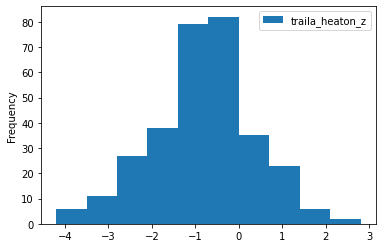

In [29]:
TrailABattery.check_battery(map_neuro)

## TrailB

In [30]:
# export 
# hide

class TrailBBattery(AbstractBattery):
    
    section = 'Trail Making Test'
    
    @staticmethod
    def from_defaults(root_data = 'data/', final_cols = None):
        
        heaton_gender = CategoricalOp('sex', {'male': 1, 'female': 2, 1: 1, 2: 2}, 'heaton_gender')
        heaton_race = CategoricalOp('race', {'AA': 1, 'white': 2, 'asian': 2, 2: 1, 1: 2}, 'heaton_race')        
        heaton_scaling = pd.read_csv('data/norms/from_kate/sheets/Heaton.csv')
        trailb_scaling = create_scaling(heaton_scaling, 'trailb', 'trailb_scaled')
        
        trailb_heaton_2 = MultiLookupOp.from_sheet_format('data/norms/from_kate/sheets/TrailsB.csv',
                                                          HEATON_MAPPINGS,
                                                          ['age', 'heaton_gender','heaton_race',  'education'],
                                                          'trailb_scaled',
                                                          'trailb_heaton_z',
                                                          extra_filter = 'heaton_race == 2')
        
        trailb_heaton_1 = MultiLookupOp.from_sheet_format('data/norms/from_kate/sheets/TrailsB_AA.csv',
                                                          HEATON_MAPPINGS,
                                                          ['age', 'heaton_gender','heaton_race',  'education'],
                                                          'trailb_scaled',
                                                          'trailb_heaton_z',
                                                          extra_filter = 'heaton_race == 1')
        trailb_heaton_1.incoperate(trailb_heaton_2)
        scaler = TestCalculator('trailB_scaling',
                               [heaton_gender, heaton_race,
                                AbstractOperation.from_config(trailb_scaling),
                                trailb_heaton_1
                               ])
        
        if final_cols is None:
            final_cols = ['trailb_heaton_z']
        
        return TrailBBattery(scaler, 
                             final_cols)

Input: 
 age:59
 education:10
 race:AA
 sex:male
 trailb:130.0
Calculating: ['heaton_gender']
sex:male -> heaton_gender:1 

Calculating: ['heaton_race']
race:AA -> heaton_race:1 

Calculating: ['trailb_scaled']
trailb matched 124, scaled to 6 

Calculating: ['trailb_heaton_z']
Matched: (heaton_race == 1) & ((age >= 50) & ((9 < education) & (education <= 12)) & (heaton_gender == 1))
Mapped to: 37.0
Scaled to: z=-1.3 

Resulting in: 
 heaton_gender:1
 heaton_race:1
 trailb_heaton_z:-1.3
 trailb_scaled:6
None


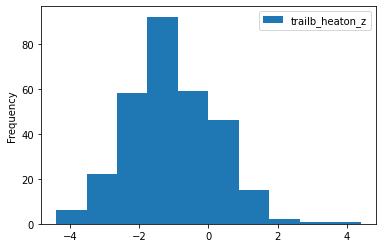

In [31]:
TrailBBattery.check_battery(map_neuro)

## WAIS-4 Digit-Symbol Coding

Currently only a placeholder.

In [43]:
# export 
# hide

class WAIS4DigitSymbolBattery(AbstractBattery):
    
    section = 'WAIS-III Coding and Copy'
    
    @staticmethod
    def from_defaults(root_data = 'data/', final_cols = None):
        
        total_op = EquationOp('digitspan',
                              'digitsforward+digitsbackward+digitssequencing',
                              ['digitsforward', 'digitsbackward', 'digitssequencing'])
        plc_op = EquationOp('digitspan_plc',
                              'digitspan',
                              ['digitspan'])
        dfs_op = ReverseLookupOp.from_sheet_format('data/norms/from_kate/sheets/DSF.csv', 
                                                   'digitsforward', 'digitsforward_wais4_z')
        dbs_op = ReverseLookupOp.from_sheet_format('data/norms/from_kate/sheets/DSB.csv', 
                                                   'digitsbackward', 'digitsbackward_wais4_z')
        dss_op = ReverseLookupOp.from_sheet_format('data/norms/from_kate/sheets/DSS.csv', 
                                                   'digitssequencing', 'digitssequencing_wais4_z')
        
        scaler = TestCalculator('wais4_digit',
                                [total_op, plc_op,
                                 dfs_op, dbs_op, dss_op])
        
        if final_cols is None:
            final_cols = ['digitsforward_wais4_z', 
                          'digitsbackward_wais4_z',
                          'digitssequencing_wais4_z']

        
        return WAIS4DigitSymbolBattery(scaler, 
                                       final_cols,
                                       z_scaled=False)

Input: 
 age:70.0
 digitsbackward:4.0
 digitsforward:8.0
 digitssequencing:1.0
Calculating: ['digitspan']
Used Equation: digitsforward+digitsbackward+digitssequencing = 13.0 = digitspan 

Calculating: ['digitspan_plc']
Used Equation: digitspan = 13.0 = digitspan_plc 

Calculating: ['digitsforward_wais4_z']
Matched: (70 <= age) & (age < 75)
Mapped to: 8.0
Scaled to: z=-0.6666666666666666 

Calculating: ['digitsbackward_wais4_z']
Matched: (70 <= age) & (age < 75)
Mapped to: 5.0
Scaled to: z=-1.6666666666666667 

Calculating: ['digitssequencing_wais4_z']
Matched: (70 <= age) & (age < 75)
Mapped to: 2.0
Scaled to: z=-2.6666666666666665 

Resulting in: 
 digitsbackward_wais4_z:-1.6666666666666667
 digitsforward_wais4_z:-0.6666666666666666
 digitspan:13.0
 digitspan_plc:13.0
 digitssequencing_wais4_z:-2.6666666666666665
None


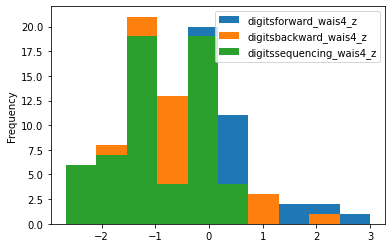

In [44]:
WAIS4DigitSymbolBattery.check_battery(map_neuro)

## Modified Wisconson Card Sort

Currently only a placeholder.

In [34]:
# export 
# hide

class mWCSTBattery(AbstractBattery):
    
    section = 'M-WCST'
    
    @staticmethod
    def from_defaults(root_data = 'data/'):
        
        test_definition = os.path.join(root_data, 'norms/placeholders/mWCST.yaml')
        calc = TestCalculator.from_config(yaml.full_load(open(test_definition)))
        
        return mWCSTBattery(calc, 
                                [], 
                                z_scaled=False)

In [35]:
mWCSTBattery.check_battery(map_neuro)

Input: 
 mwcstcat:6.0
 mwcsterrors:5.0
 mwcstpersev:2.0
Calculating: ['mwcstcat_plc']
Used Equation: mwcstcat = 6.0 = mwcstcat_plc 

Calculating: ['mwcstpersev_plc']
Used Equation: mwcstpersev = 2.0 = mwcstpersev_plc 

Calculating: ['mwcsterrors_plc']
Used Equation: mwcsterrors = 5.0 = mwcsterrors_plc 

Calculating: ['mwcstpercentpersev']
Used Equation: 100*mwcstpersev/mwcsterrors = 40.0 = mwcstpercentpersev 

Calculating: ['mwcstpercentpersev_plc']
Used Equation: mwcstpercentpersev = 40.0 = mwcstpercentpersev_plc 

Resulting in: 
 mwcstcat_plc:6.0
 mwcsterrors_plc:5.0
 mwcstpercentpersev:40.0
 mwcstpercentpersev_plc:40.0
 mwcstpersev_plc:2.0
None


## Stroop

In [36]:
# export 
# hide

class StroopBattery(AbstractBattery):
    
    section = 'Stroop Test'
    
    @staticmethod
    def from_defaults(root_data = 'data/', final_cols = None):
        
        stroop_test_definition = os.path.join(root_data, 'norms/norman/norman_stroop_regnorm.yaml')
        stroop_calc = TestCalculator.from_config(yaml.full_load(open(stroop_test_definition)))
        
        inter_op = EquationOp('stroop_interference',
                              'stroopcolorword-(stroopword*stroopcolor)/(stroopword+stroopcolor)',
                              ['stroopcolorword', 'stroopword', 'stroopcolor'])
        
        stroop_calc = stroop_calc + TestCalculator('stroop_extra', [inter_op])

        
        if final_cols is None:
            final_cols = ['stroopword_norman_z', 'stroopcolor_norman_z', 'stroopcolorword_norman_z']
        
        return StroopBattery(stroop_calc, final_cols)

Possible exessive Nans: stroopword_norman_z: 0.6613418530351438, stroopcolor_norman_z: 0.6613418530351438, stroopcolorword_norman_z: 0.6613418530351438
Input: 
 age:59
 education:10
 race:AA
 sex:male
 stroopcolor:nan
 stroopcolorword:nan
 stroopword:nan
Calculating: ['norman_gender']
sex:male -> norman_gender:0 

Calculating: ['norman_race']
race:AA -> norman_race:1 

Calculating: ['stroopcolor_scaled']
Could not find matching bin for nan 

Calculating: ['stroopcolorword_scaled']
Could not find matching bin for nan 

Calculating: ['stroopword_scaled']
Could not find matching bin for nan 

Calculating: ['stroopcolor_norman_z']
Matched (norman_race == 1) & ((age >= 18) & (age <= 66)), applied ((stroopcolor_scaled - (0.3102*(education-13.92)+(-0.1006)*(age-40.67)+1.4915*norman_gender+8.2672))/2.6643)*10+50 = nan 

Calculating: ['stroopcolorword_norman_z']
Matched (norman_race == 1) & ((age >= 18) & (age <= 66)), applied ((stroopcolorword_scaled - (0.2363*(education-13.94)+(-0.1219)*(age-

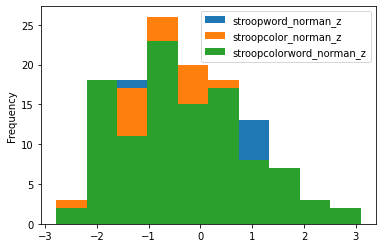

In [37]:
StroopBattery.check_battery(map_neuro)

In [38]:
# export

class MMSEBattery(AbstractBattery):
    
    section = 'MMSE'
    
    
    @staticmethod
    def from_defaults(root_data = 'data/', final_cols = None):
        
        inter_op = EquationOp('mmse_plc',
                              'mmse',
                              ['mmse'])
        calc = TestCalculator('mmse_extra', [inter_op])
        
        if final_cols is None:
            final_cols = ['mmse_plc']
        
        return MMSEBattery(calc, final_cols, 
                             z_scaled=False)

Input: 
 mmse:29.0
Calculating: ['mmse_plc']
Used Equation: mmse = 29.0 = mmse_plc 

Resulting in: 
 mmse_plc:29.0
None


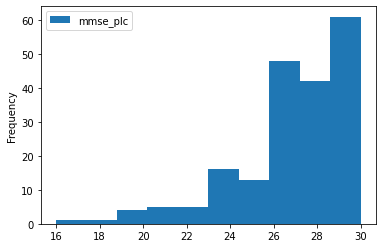

In [39]:
MMSEBattery.check_battery(map_neuro)

In [40]:
# export

class DemographicsBattery(AbstractBattery):
    
    @staticmethod
    def from_defaults(root_data = 'data/', final_cols = None):
        
        race_op  = CategoricalOp('race', 
                                 {2: 'AA', 
                                  1: 'white', 
                                  3: 'asian',
                                  'AA': 'AA',
                                  'white': 'white',
                                  'asian': 'asian',
                                 }, 'race_desc')
        
        calc = TestCalculator('demographics', [race_op])
        
        if final_cols is None:
            final_cols = ['race_desc']
        
        return DemographicsBattery(calc, final_cols, 
                                   z_scaled=False)
    



In [41]:
demo_bat = DemographicsBattery.from_defaults()
demos = demo_bat.scaled_data(map_neuro)
demos.head()

race_desc
PatientID Visit          
1         1            AA
          2            AA
2         1            AA
          2            AA
4         1            AA